In [ ]:
import line_utils
import os

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Establish the path the Excel file
base_path = "/Users/zachcm/Documents/Projects/ExM_Nadja/01_Macros_Analysis/"
workbook = "20241008_septin2_tubulin.xlsx"
workbook_path = os.path.join(base_path, workbook)
expected_colnames=['Distance_(microns)', 'MTs', 'septin2', 'DAPI']


In [3]:
# Load the table of contents
toc = pd.read_excel(workbook_path, sheet_name="ToC + P-t-p", header=2)

In [4]:
# load FWHM_along, which contains other statistics
metrics = pd.read_excel(workbook_path, sheet_name="FWHM_along", header=0).dropna(axis=0)

In [5]:
# Let's merge information from toc with metrics
metrics["dX (µm)"] = 0
metrics["Angle"] = np.nan
metrics["X"] = np.nan
metrics["Y"] = np.nan
metrics["length"] = np.nan
for i, ml in metrics.iterrows():
    # print(ml)
    for j, tl in toc.iterrows():
        try:
            if tl["Label"].startswith(ml["Label"]):
                # print(ml["Label"], tl["dX (µm)"])
                if not np.isnan(tl["dX (µm)"]):
                    metrics.loc[i,"dX (µm)"] = tl["dX (µm)"]
                metrics.loc[i,"X"] = tl["X"]
                metrics.loc[i,"Y"] = tl["Y"]
                metrics.loc[i,"length"] = tl["length"]
                metrics.loc[i,"Angle"] = tl["Angle"]
        except (AttributeError, TypeError):
            pass
metrics = metrics.dropna()

In [6]:
# Now let's get the original images 
import glob 

max_proj_path = "/Volumes/Ries_Ewers/Septin2-GFP/MaxIPs"
max_proj_files = glob.glob(max_proj_path+"/*.tif")

In [ ]:
import tifffile

from skimage.filters import threshold_otsu

from contour import image_quadtree
from contour import dual_grid_2d
from contour import marching_squares
from contour.util.contour import find_contours, find_connections

plt.rcParams.update({'font.size': 8})

# Now let's add the curvature metric
metrics["curvature"] = np.nan

# M, N = 20, 4
# fig, axs = plt.subplots(M, N, figsize=(16,80))
# j = -1
for i, ml in metrics.iterrows():
    # j += 1
    # Get the image associated with this row
    label = ml["Label"]
    im = None
    for fn in max_proj_files:
        if label in fn:
            im = tifffile.imread(fn)
            break

    # construct quadtree
    qt = image_quadtree.ImageQuadtree(0, density_function=np.std)
    qt.add_image(im.max(0))
    
    # construct dual grid
    dg = dual_grid_2d.DualGrid2D(qt)
    
    # get lines
    try:
        ms = marching_squares.MarchingSquares(isolevel=np.mean(dg.values)-np.std(dg.values)/2)
        ms.add_points(dg.vertices, dg.values)
        ms.march()
    except ValueError:
        ms = marching_squares.MarchingSquares(isolevel=np.mean(dg.values))
        ms.add_points(dg.vertices, dg.values)
        ms.march()
    
    # get contours
    contours = find_contours(ms._lines)
    
    # threshold_perimeter = np.mean(np.array([contour.perimeter for contour in contours]))
    # threshold_perimeter = np.sort(np.array([contour.perimeter for contour in contours]))[-3]+1
    try:
        threshold_diameter = np.sort(np.array([contour.diameter for contour in contours]))[-3]+1
    except IndexError:
        try:
            threshold_diameter = np.sort(np.array([contour.diameter for contour in contours]))[-2]+1
        except IndexError:
            threshold_diameter = 0 # np.sort(np.array([contour.diameter for contour in contours]))[-1]+1
    

    curvatures = []

    # axs[j // N, j % N ].imshow(np.log(im.max(0)), cmap='gray')
    # axs[j // N, j % N ].set_axis_off()
    for contour in contours:
        # if contour.perimeter < threshold_perimeter:
        #     continue
        if contour.diameter < threshold_diameter:
            continue

        curvatures.extend(contour.curvature)

        # for line in contour.lines:
        #     # print(line.shape)
        #     axs[j // N, j % N ].plot(line[:,0], line[:,1])

        # axs[j // N, j % N ].plot(contour.vertices[:,0], contour.vertices[:,1])

    metrics.loc[i,"curvature"] = np.nanmedian(curvatures)
    # axs[j // N, j % N ].set_title(f"{np.nanmedian(curvatures):.2f} {ml['Unnamed: 0']}")

# while j < 79:
#     j+= 1
#     axs[j // N, j % N ].set_axis_off()

metrics = metrics.dropna()
# fig.tight_layout()

<Axes: xlabel='Unnamed: 0', ylabel='curvature'>

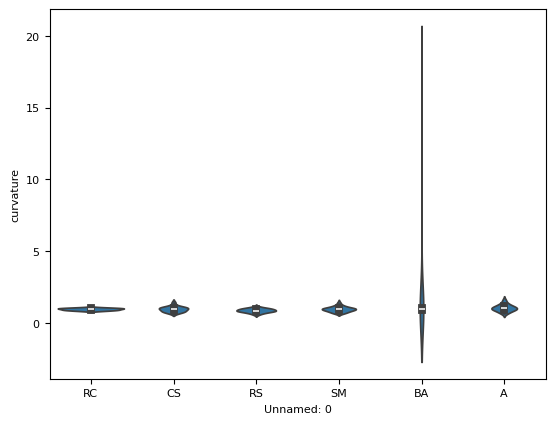

In [8]:
import seaborn as sns

sns.violinplot(data=metrics, x='Unnamed: 0', y='curvature')

Text(0, 0.5, 'PC2')

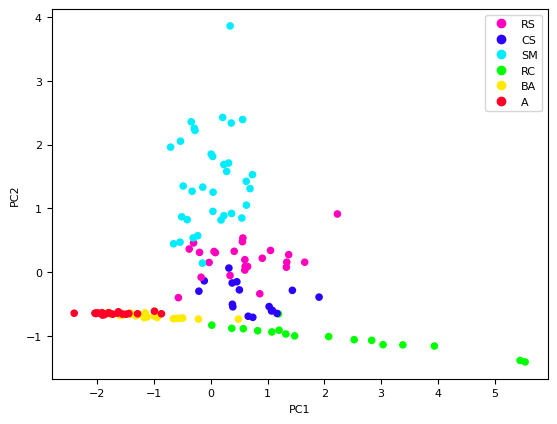

In [16]:
# Plot PCA space 

features = metrics[[ "diamM", "diamA", "dX (µm)"]]#, "curvature"]]
# features = features / features.sum(0)
# features = np.array(features) / np.array(features).sum(0)[None,:]
# features = features / features.sum(1)[:,None]
features = (features - features.mean(0))/features.std(0)

# stage_keys = {"RS": 0, "CS": 1, "SM": 2}
stage_keys = {"RS": 0, "CS": 1, "SM": 2, 
               "RC": 3, "BA": 4, "A": 5}
stage_cols = [stage_keys[x] for x in metrics["Unnamed: 0"]]

pca = PCA(n_components=2)
pca.fit(features)

xx, yy = pca.transform(features).T[:2,:]
scatter = plt.scatter(xx, yy, c = stage_cols, cmap='gist_rainbow_r', s=20)
plt.legend(scatter.legend_elements(num=len(stage_keys)-1)[0],list(stage_keys.keys()))
# plt.axis([-0.2, 0.8, -0.5, 0.1])
plt.xlabel('PC1')
plt.ylabel('PC2')

In [17]:
pca.explained_variance_

array([1.93182268, 1.00590708])

Text(0, 0.5, 'PC2')

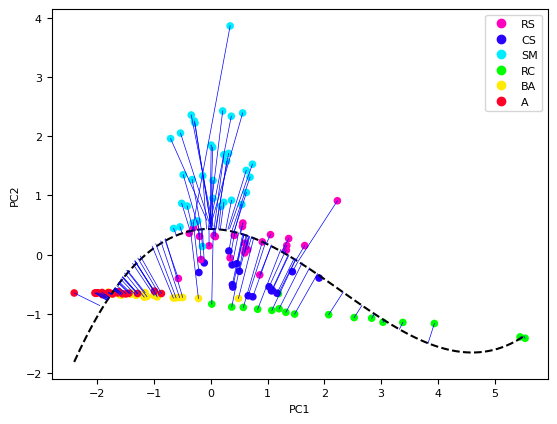

In [18]:
# fit a spline through pca space

def dpoly(p):
    """p(x) = p[0] * x**deg + ... + p[deg]"""
    N = len(p)
    dp = []
    for i, coef in enumerate(p[:-1]):
        dp.append((N-i-1)*coef)
    return dp

def point_poly_dist(x0, y0, p, return_coords=True):
    """ (x0, y0) is a point, p is a poly as defined in np.polyfit """

    # find the derivative line at x
    # y = m*x+b
    z = np.poly1d(p)
    dfit = np.poly1d(dpoly(p))
    b = z(x0)-dfit(x0)*x0
    m = dfit(x0)

    dist = np.abs(b+m*x0-y0)/(1+m*m)

    if return_coords:
        xp = (x0 + m*y0 - m*b)/(m*m+1)
        yp = m*xp+b

        return (dist, xp, yp)

    return dist

fit = np.polyfit(xx, yy, 3)
xxx = np.linspace(np.min(xx),np.max(xx),100)
z = np.poly1d(fit)(xxx)

dfit = np.poly1d(dpoly(fit))

scatter = plt.scatter(xx, yy, c = stage_cols, cmap='gist_rainbow_r', s=20)

# plot fit
plt.plot(xxx, z, linestyle='--', c='k')
# Add directionality to the fit
# plt.arrow(xxx[-2], z[-2], xxx[-1], z[-1]-z[-2], shape='full', lw=0, length_includes_head=True, head_width=.05, color="k")

# plot the derivative
# i = 80
# plt.plot(xxx[(i-10):(i+10)], dfit(xxx[i])*xxx[(i-10):(i+10)]+z[i]-dfit(xxx[i])*xxx[i], color='b', linewidth=2)

# plot shortest path from each point to the line
dist, xp, yp = point_poly_dist(xx, yy, fit)
permutation = np.argsort(xp)

for i in range(len(xp)):
    plt.plot([xx[i], xp[i]], [yy[i], yp[i]], c='b', linewidth=0.5)

plt.legend(scatter.legend_elements(num=len(stage_keys)-1)[0],list(stage_keys.keys()))
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
# # fit and plot traveling salesman 

# from python_tsp.heuristics import solve_tsp_simulated_annealing

# # construct a distance matrix and compute the traveling salesman path
# idxs = np.argsort(xx)[::-1]
# xx2 = xx[idxs]
# yy2 = yy[idxs]
# stage_cols2 = np.array(stage_cols)[idxs]

# dist = np.sqrt((xx2[:,None] - xx2[None,:])**2 + (yy2[:,None]-yy2[None,:])**2)
# dist[:, 0] = 0

# permutation, distance = solve_tsp_simulated_annealing(dist)

# scatter = plt.scatter(xx2, yy2, c = stage_cols2, cmap='gist_rainbow_r')
# plt.plot(xx2[np.array(permutation)], yy2[np.array(permutation)])
# # plt.plot(xx[np.array(permutation)], yy[np.array(permutation)])
# plt.legend(scatter.legend_elements(num=len(stage_keys)-1)[0],list(stage_keys.keys()))
# # plt.axis([-0.2, 0.8, -0.5, 0.1])
# plt.xlabel('PC1')
# plt.ylabel('PC2')

In [ ]:
import scipy.ndimage as ndi

def rot_and_trans_from_line_profile(im, angle, x, y, N=2048):
    if np.any([N < x for x in im.shape]):
        raise Exception("Padding is smaller than image size. Increase N.")
    if len(im.shape) != 3:
        raise Exception("This only works for images of size 3. TODO: Extend.")

    # Pad the image
    im_pad = np.zeros((3,N,N), dtype=im.dtype)
    x_off, y_off = (N-im.shape[1])//2, (N-im.shape[2])//2
    im_pad[:,x_off:(x_off+im.shape[1]),y_off:(y_off+im.shape[2])] = im

    # Now translate
    x_shift = int(im.shape[1]//2-y)
    y_shift = int(im.shape[2]//2-x)
    im_trans = np.roll(np.roll(im_pad, x_shift, axis=1), y_shift, axis=2)

    # And rotate
    im_rot = ndi.rotate(im_trans, -angle, axes=(2,1), reshape=False)

    return im_rot

In [20]:
import tifffile

# Loop over these files

files = []
images = []

# for i, label in zip(idxs[permutation], metrics.iloc[idxs[permutation]]['Label']):
for i, label in zip(permutation, metrics.iloc[permutation]['Label']):
    print(i, label)
    for fn in max_proj_files:
        if label in fn:
            files.append(fn)
            im = tifffile.imread(fn)
            im_rot = rot_and_trans_from_line_profile(im, 
                                                     metrics['Angle'].iloc[i], 
                                                     metrics['X'].iloc[i],
                                                     metrics['Y'].iloc[i])
            images.append(im_rot)
            break

# >>> data = numpy.random.randint(0, 255, (30, 301, 219), 'uint8')
# >>> with TiffWriter('temp.tif') as tif:
# ...     for frame in data:
# ...         tif.write(frame, contiguous=True)
# ...

129 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_19.tif
118 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_35.tif
134 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_45min_53.tif
127 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_21.tif
126 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_23.tif
133 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_02.tif
94 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_24.tif
131 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_10.tif
124 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_26.tif
130 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_12.tif
99 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_14.tif
95 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_22.tif
128 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_75min_20.tif
117 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_45min_33.tif
113 20240723_NRK49FS2GFP_UExM_GFP-488_aTub-568_DAPI_45min_10.tif
122 20240723_NRK49FS2GFP_UEx

In [21]:
images = np.array(images)
tifffile.imwrite("septin2_proj.tif", images[::-1,...])

In [ ]:
plt.imshow(np.log(im[1,...]),cmap='gray')

In [ ]:
import scipy.ndimage as ndi

gauss_20 = ndi.gaussian_filter(im[1:,...].max(0),20)
gauss_10 = ndi.gaussian_filter(im[1:,...].max(0),10)
gauss_diff = gauss_10.astype(float)-gauss_20.astype(float)
# gauss_diff = ndi.gaussian_laplace(im.max(0),sigma=3)

plt.imshow(gauss_diff, cmap='gray')